In [17]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tqdm import tqdm
import pathlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import re

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
EPOCHS = 10

IMG_WIDTH = 1024
IMG_HEIGHT = 1024
IMG_CHANNELS = 3

PATH = "G:/data/global-wheat-detection/"

In [3]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

In [4]:
train_df = pd.read_csv(f'{PATH}train.csv')
train_df.shape

(147793, 5)

In [5]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [6]:
df = train_df.copy()

In [7]:
def make_polygon(coords):
    xm, ym, w, h = coords
    polygon = [(xm, ym), (xm, ym + h), (xm + w, ym + h), (xm + w, ym)]
    return polygon

In [8]:
masks = dict()
for img_id, gp in tqdm(df.groupby("image_id")):
    gp['polygons'] = gp['bbox'].apply(eval).apply(lambda x: make_polygon(x))
    img = Image.new('L', (IMG_WIDTH, IMG_WIDTH), 0)
    for pol in gp['polygons'].values:
        ImageDraw.Draw(img).polygon(pol, outline=1, fill=1)

    mask = np.array(img, dtype=np.uint8)
    masks[img_id] = mask

  0%|                                                                                         | 0/3373 [00:00<?, ?it/s]D:\anaconda\anaconda3\envs\CNN\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|█████████████████████████████████████████████████████████████████████████████| 3373/3373 [00:10<00:00, 321.88it/s]


In [11]:
img_dir = os.path.join(PATH, "train/")

In [12]:
ids_train = list(train_df['image_id'].unique())
x_train_filenames = []
for img_id in ids_train:
    x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))

In [13]:
X_train = np.zeros((len(ids_train), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(ids_train), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [19]:
for n, id_ in tqdm(enumerate(ids_train[:]), total=len(ids_train)):
    image_path = img_dir + id_ + '.jpg'
    img = Image.open(image_path)    
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    id_clean = id_.split('.')[0]
    if id_clean in masks.keys():
        Y_train[n] = masks[id_clean][:, :, np.newaxis]

100%|██████████████████████████████████████████████████████████████████████████████| 3373/3373 [03:13<00:00, 17.42it/s]


In [20]:
X_train.shape, Y_train.shape

((3373, 1024, 1024, 3), (3373, 1024, 1024, 1))

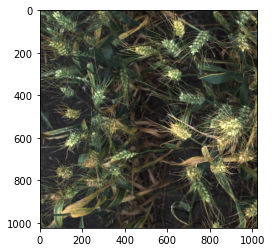

In [21]:
x=2
plt.imshow(X_train[x])

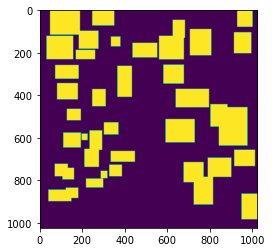

In [23]:
plt.imshow(Y_train[x,:,:,0].astype(int))

In [ ]:
new_columns = ['x_min','y_min', 'width', 'height']

In [ ]:
train_df[new_columns] = pd.DataFrame(\
                      [re.findall('(\d+\.\d+)', x) for x in train_df.bbox.tolist()], index= train_df.index)
train_df = train_df[['image_id', 'bbox', 'source', 'x_min', 'y_min', 'width', 'height']]
train_df

In [ ]:
for i in new_columns:
    train_df[i] =train_df[i].astype(float)

In [ ]:
source_list = list(train_df['source'].unique())

In [ ]:
train_df['source_id'] = train_df['source']

In [ ]:
train_df.source_id.replace(source_list, [i for i in range (len(source_list))], inplace=True) 

In [ ]:
def display_images(images): 
    f, ax = plt.subplots(3,3, figsize=(18,22))
    for i, image_id in enumerate(images):
        image_path = os.path.join(img_dir, f'{image_id}.jpg')
        image = Image.open(image_path)
        
        draw = ImageDraw.Draw(image)
        bboxes = train_df.loc[train_df['image_id'] == image_id]
        for j, row in bboxes.iterrows():    
            draw.rectangle([(row.get('x_min'), row.get('y_min')),\
                            (row.get('x_min') + row.get('width'), row.get('y_min') + row.get('height'))], width=3)
            
        ax[i//3, i%3].imshow(image) 
        image.close()       
        ax[i//3, i%3].axis('off')

        source = train_df[train_df['image_id'] == image_id]['source'].values[0]
        ax[i//3, i%3].set_title(f"image_id: {image_id}\nSource: {source}")

    plt.show() 

In [ ]:
images = train_df.sample(n=9, random_state=34)['image_id'].values
display_images(images)